In [134]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [135]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey


from flask import Flask, jsonify

engine = create_engine("sqlite:///hawaii.sqlite")


# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


# Save tables reference to:
Measurement = Base.classes.measurement
Stations = Base.classes.station

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


# Create our session (link) from Python to the DB
session = Session(bind = engine)




In [136]:
# We can view all of the classes that automap found
Base.classes.keys()



['measurement', 'station']

In [137]:
# Verify tables and structure from SQLite database

inspector = inspect(engine)
table_names = ('Measurement','Station')

i =1 
for table in table_names:
    print("Table "+str(i)+": "+str(table))
    i = i+1
    print()
    columns = inspector.get_columns(table)
    for col in columns:
        print("     Column: "+str(col["name"])+" ("+str(col["type"])+")")

Table 1: Measurement

     Column: id (INTEGER)
     Column: station (TEXT)
     Column: date (TEXT)
     Column: prcp (FLOAT)
     Column: tobs (FLOAT)
Table 2: Station

     Column: id (INTEGER)
     Column: station (TEXT)
     Column: name (TEXT)
     Column: latitude (FLOAT)
     Column: longitude (FLOAT)
     Column: elevation (FLOAT)


In [138]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [139]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [140]:
# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [141]:
# Calculate the date 1 year ago from the last data point in the database 

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [142]:
# Select only the date and prcp values
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Sort the DataFrame values by date.

rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

rain_df = pd.DataFrame(rain)
rain_df.set_index('date').head()
rain_df.head()



,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


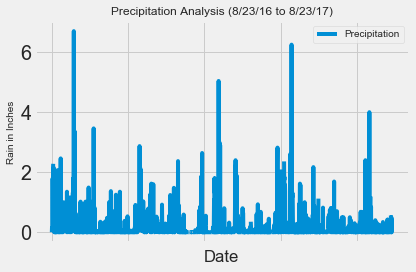

In [143]:
# plot the dataframe

rain_df.plot('date','prcp')
plt.xlabel("Date")
#rotate the x labels 45 degrees

plt.ylabel("Rain in Inches", fontsize=10)
plt.title("Precipitation Analysis (8/23/16 to 8/23/17)", fontsize=12)
plt.legend(["Precipitation"], fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [144]:
# Use Pandas to calcualte the summary statistics for the precipitation 

rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [145]:
# Design a query to calculate the total number of stations

locations = session.query(Measurement).group_by(Measurement.station).count()
print("{} is the total number of stations in this dataset.".format(locations))


9 is the total number of stations in this dataset.


In [146]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

stationm = most_active[0][0]    
print("The most active station was",stationm,"with",most_active[0][1],"rows.")
print()
print("List of the Stations in descending order")
for station, count in most_active:
    print("Station",station,"has",count, "rows.")

The most active station was USC00519281 with 2772 rows.

List of the Stations in descending order
Station USC00519281 has 2772 rows.
Station USC00519397 has 2724 rows.
Station USC00513117 has 2709 rows.
Station USC00519523 has 2669 rows.
Station USC00516128 has 2612 rows.
Station USC00514830 has 2202 rows.
Station USC00511918 has 1979 rows.
Station USC00517948 has 1372 rows.
Station USC00518838 has 511 rows.


In [147]:
# Finding most active station 

most_active_station=stationm[0][0]
print(f"Most Active Station: {stationm}")


Most Active Station: USC00519281


In [148]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == stationm).\
                filter(Measurement.date >= last_year).all()
tobs_df = pd.DataFrame(temp_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


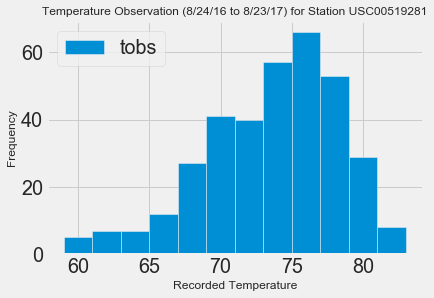

In [149]:
# Plot the results as a histogram with `bins=12`.
    
temp_df=pd.DataFrame(temp_results)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Temperature Observation (8/24/16 to 8/23/17) for Station " + stationm, fontsize=12)
plt.legend(["tobs"])
plt.show()
   

# STEP 2 - Climate App

In [ ]:
import datetime as dt
from dateutil.relativedelta import relativedelta
import datetime as dt 
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify 


#Database Setup

engine = create_engine('sqlite:///hawaii.sqlite', connect_args={'check_same_thread': False})


# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


# Save tables reference to:
Measurement = Base.classes.measurement
Stations = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(bind = engine)


# Set up Flask and landing page

app = Flask(__name__)

# Set variable last 12 months 
last_year= '2016-08-23'

app = Flask(__name__)
# List of all API routes that are available

@app.route("/")
def welcome():
    return (
      f"<p>Welcome to the HAWAII WEATHER API!</p>"
      f"<p>Usage:</p>"
      f"/api/v1.0/precipitation<br/>Returns a JSON list of prcpt data. Dates between 8/23/16 and 8/23/17<br/><br/>"
      f"/api/v1.0/stations<br/>Returns a JSON list of the weather stations and their names<br/><br/>"
      f"/api/v1.0/tobs<br/>Returns a JSON list of the Temp. Obs. (tobs) for each station. Dates btw 8/23/16 and 8/23/17<br/><br/>"
      f"/api/v1.0/start<br/>Returns a JSON list of the min. temp., avg temp. and max temp..Dates between the given start date and 8/23/17<br/><br/>."
      f"/api/v1.0/start/end<br/>Returns a JSON list of the min. temp., avg. temp. and max temp.Dates between the given start date and end date<br/><br/>."
    )


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

# /api/v1.0/precipitation
# Convert the query results to a Dictionary using date as the key and prcp as the value.
# Return the JSON representation of the dictionary.


@app.route("/api/v1.0/precipitation")
def precipitation():
    
# Query all dates and preciptations for last year  
# Last 12 months 

    last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()
    
# Convert query results to dictionary, convert the list of tuples into normal list 
# and  return jsonify

    precipitation_list = []
    for precip in rain:
        precip_dict = {}
        precip_dict["date"] = precip.date
        precip_dict["prcp"] = precip.prcp
        precipitation_list.append(precip_dict)
        return jsonify(precipitation_list)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  


# /api/v1.0/stations
# Return a JSON list of stations from the dataset.

@app.route("/api/v1.0/stations")
def stations():
    list_stations= session.query(Stations.station, Stations.name).all()
    return jsonify(list_stations)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  


# /api/v1.0/tobs
# query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.

@app.route("/api/v1.0/tobs")
def tobs():
    temp_results = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date >= last_year).all()
    return jsonify(temp_results)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  


# /api/v1.0/<start>
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.


@app.route('/api/v1.0/<start>/')
def temp_obs(start):
   
   
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start).all()
    
    # Convert list of tuples into normal list
    temp_obs = list(np.tmp(results))

    return jsonify(temp_obs)

    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  


# /api/v1.0/<start>/<end>
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

@app.route("/api/v1.0/<start>/<end>")
def temp_obs_start_end(start, end):
    
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start).\
                filter(Measurement.date <= end).all()
    
    # Convert list of tuples into normal list
    temp_obs_start_end = list(np.ravel(results))

    return jsonify(temp_obs_start_end)



if __name__ == "__main__":
    app.run(debug=True)

# Optional: Other Recommended Analyses

In [150]:

temp_results1 = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= last_year).all()
tobs1_df = pd.DataFrame(temp_results1)
tobs1_df.head()

,date,tobs
0,2016-08-23,81.0
1,2016-08-24,79.0
2,2016-08-25,80.0
3,2016-08-26,79.0
4,2016-08-27,77.0


In [151]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2016-08-23', '2017-08-24'))

[(58.0, 74.59058295964125, 87.0)]


In [153]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Use the calc_temps function to calculate the min, avg, and max 
# temperatures for your trip using the matching dates from the previous year
# (i.e., use "2017-01-01" if your trip start date was "2018-01-01").


temp_results = calc_temps('2017-03-12', '2018-03-12')
temp_results



[(58.0, 76.04261954261955, 87.0)]

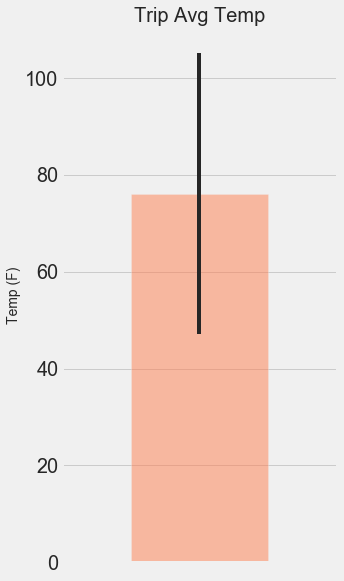

In [154]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

temp_df = pd.DataFrame(temp_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = temp_df['Avg Temp']
min_max_temp = temp_df.iloc[0]['Max Temp'] - temp_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(5,8), alpha=0.5, color='coral')
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)", fontsize=14)
plt.tight_layout()
plt.title("Trip Avg Temp", fontsize=20)
plt.show()





In [155]:
#Calcualte the rainfall per weather station using the previous year's matching dates.

number_station = session.query(Measurement.station, func.sum(Measurement.prcp).label('rainfall')).\
                 filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
                 group_by(Measurement.station).\
                 order_by('rainfall').all()                



print("Rainfall per weather station: Between 2016-08-23, 2017-08-23")
print()
number_station


Rainfall per weather station: Between 2016-08-23, 2017-08-23



[('USC00517948', 4.59),
 ('USC00519397', 16.089999999999986),
 ('USC00514830', 33.239999999999995),
 ('USC00519523', 38.01),
 ('USC00513117', 48.510000000000026),
 ('USC00519281', 70.03000000000003),
 ('USC00516128', 147.81000000000006)]

In [156]:
# Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [157]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

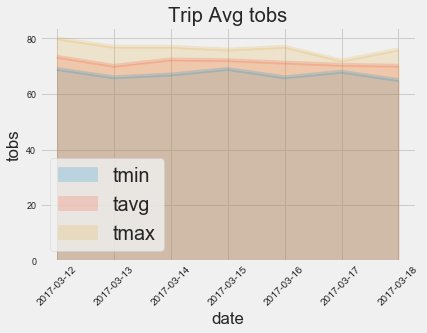

In [165]:
def start_date(day):
   
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%y-%m-%d", Measurement.date) == date).all()
    

# Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.


dates = ['2017-03-12','2017-03-13','2017-03-14','2017-03-15','2017-03-16','2017-03-17','2017-03-18']
tmin = []
tmax = []
tavg = []
for day in dates:
    trip_avg = daily_normals(day)
    tmin.append(trip_avg ['min'])
    tmax.append(trip_avg ['max'])
    tavg.append(trip_avg ['avg'])

# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
trip_avg_df = pd.DataFrame({
    'date': dates,
    'tmin': tmin,
    'tavg': tavg,
    'tmax': tmax
})


# Use Pandas to plot an area plot (stacked=False) for the daily normals.
plt1 = trip_avg_df.plot.area(stacked=False, alpha=0.2,fontsize=9)
plt.xticks([0,1,2,3,4,5,6],dates, fontsize=10)
plt.xticks(rotation='45')
plt1.set_xlabel('date')
plt1.set_ylabel('tobs')
plt.title(f'Trip Avg tobs')


plt.show()